In [7]:
# ==== CONFIG ====
RUN_POC = False          # Proof Of Concept (few subjects, 1 night, no HMM)
RUN_CV  = True         # 5-fold subject-wise CV + HMM smoothing

POC_SUBJECTS   = [0, 1, 2]
POC_RECORDINGS = [1]

CV_SUBJECTS    = list(range(20))   # Sleep-EDF subjects 0..19
CV_RECORDINGS  = [1]               # Some patients missing nights. stick with [1] for now.

TARGET_HZ      = 50                # resample target
EPOCHS_POC     = 10
EPOCHS_CV      = 15
NUM_WORKERS    = 2                 
RESULTS_DIR    = "artifacts"


In [2]:
import os, math, json, random
import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,
    cohen_kappa_score, precision_recall_fscore_support
)
from sklearn.model_selection import KFold

import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.filter import resample as mne_resample

# seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True  

os.makedirs(RESULTS_DIR, exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)


Device: cuda


In [ ]:
def _match_ch(raw, target):

    if target in raw.ch_names: return target
    pref = f"EEG {target}"
    if pref in raw.ch_names: return pref
    hits = [c for c in raw.ch_names if target.replace('-','') in c.replace('-','')]
    return hits[0] if hits else None

def load_record(psg_path, hyp_path, picks=('EEG Fpz-Cz','EEG Pz-Oz'),
                l_freq=0.3, h_freq=40., target_hz=50):
    raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
    ann = mne.read_annotations(hyp_path)
    raw.set_annotations(ann, emit_warning=False)

    sel = [c for c in (_match_ch(raw, picks[0]), _match_ch(raw, picks[1])) if c]
    assert len(sel) >= 1, f"No desired EEG channels in {raw.ch_names}"
    raw.pick(sel)

    sfreq = int(raw.info['sfreq'])
    raw.filter(l_freq, h_freq)

    # map R&K to AASM (merge stage 4 -> N3)
    stage_map = {'Sleep stage W':0,'Sleep stage 1':1,'Sleep stage 2':2,
                 'Sleep stage 3':3,'Sleep stage 4':3,'Sleep stage R':4}
    events, event_id = mne.events_from_annotations(raw, event_id=stage_map, chunk_duration=30.)
    epochs = mne.Epochs(raw, events, event_id=event_id, tmin=0, tmax=30,
                        baseline=None, preload=True, verbose=False)

    X = epochs.get_data()                    # [n_ep, n_ch, n_t]
    y = epochs.events[:, 2].astype(int)      # 0..4

    # per-epoch, per-channel z-score (no leakage)
    mu = X.mean(axis=2, keepdims=True); sd = X.std(axis=2, keepdims=True) + 1e-6
    X = (X - mu) / sd

    # anti-alias resample to target_hz
    if sfreq != target_hz:
        down = int(round(sfreq / target_hz))
        X = mne_resample(X, down=down, axis=-1)
        sfreq = target_hz

    # pad second channel if only one present
    if X.shape[1] == 1:
        X = np.concatenate([X, np.zeros_like(X)], axis=1)

    return X.astype('float32'), y, sfreq, sel

def build_subject_records(subjects, recordings=(1,), picks=('EEG Fpz-Cz','EEG Pz-Oz'), target_hz=50):
    """Fetch per-subject, skip missing nights, return dict: subj -> list of {X,y} records."""
    records = {s: [] for s in subjects}
    fs_out = None
    for s in subjects:
        paths = fetch_data(subjects=[s], recording=list(recordings),
                           on_missing='warn', verbose=False)
        for psg, hyp in paths:
            X, y, sf, _ = load_record(psg, hyp, picks=picks, target_hz=target_hz)
            records[s].append({'X': X, 'y': y})
            fs_out = sf
    # drop empty subjects (no usable nights)
    records = {s: recs for s, recs in records.items() if len(recs) > 0}
    return records, fs_out

def stack_subjects(records, subj_list):
    Xs, ys = [], []
    for s in subj_list:
        for rec in records[s]:
            Xs.append(rec['X']); ys.append(rec['y'])
    return np.concatenate(Xs, 0), np.concatenate(ys, 0)


In [ ]:
class PosEnc(nn.Module):
    def __init__(self, d_model, max_len=6000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0)/d_model))
        pe[:, 0::2] = torch.sin(pos * div); pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # [1,T,d]
    def forward(self, x):  # x: [B,T,d]
        return x + self.pe[:, :x.size(1)]

class EEGSleepTransformer(nn.Module):
    def __init__(self, n_classes=5, in_len=1500, in_ch=2, d_model=128, nhead=4, d_ff=256, p_drop=0.1):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv1d(in_ch, 32, 7, stride=2, padding=3), nn.BatchNorm1d(32), nn.GELU(),
            nn.Conv1d(32, 64, 7, stride=2, padding=3),   nn.BatchNorm1d(64), nn.GELU(),
            nn.MaxPool1d(2)
        )
        with torch.no_grad():
            T = in_len
            T = (T+6-7)//2 + 1
            T = (T+6-7)//2 + 1
            T = T//2
            self.T_tokens = int(T)

        self.proj = nn.Conv1d(64, d_model, 1)
        self.pe   = PosEnc(d_model, max_len=self.T_tokens)
        enc = nn.TransformerEncoderLayer(d_model, nhead, d_ff, batch_first=True, dropout=p_drop, activation='gelu')
        self.encoder = nn.TransformerEncoder(enc, num_layers=1)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Dropout(p_drop), nn.Linear(d_model, n_classes))

    def forward(self, x):            # x: [B,C,T]
        z = self.stem(x)             # [B,64,T’]
        z = self.proj(z).transpose(1, 2)  # [B,T’,d]
        z = self.pe(z)
        z = self.encoder(z)          # [B,T’,d]
        z = z.mean(1)                # [B,d]
        return self.head(z)          # [B,5]

def build_log_trans(alpha_stay=0.88):

    K = 5
    Tm = np.full((K, K), (1 - alpha_stay) / 8)  # tiny elsewhere
    for k in range(K):
        Tm[k, k] = alpha_stay
        if k - 1 >= 0: Tm[k, k-1] += (1 - alpha_stay) / 4
        if k + 1 < K: Tm[k, k+1] += (1 - alpha_stay) / 4
    Tm = Tm / Tm.sum(axis=1, keepdims=True)
    return np.log(Tm + 1e-12)

def viterbi_log(emissions_log, log_trans, log_init=None):

    T, K = emissions_log.shape
    if log_init is None: log_init = np.full(K, -math.log(K))
    dp = np.empty((T, K)); ptr = np.empty((T, K), dtype=np.int32)
    dp[0] = log_init + emissions_log[0]
    for t in range(1, T):
        scores = dp[t-1][:, None] + log_trans
        ptr[t] = scores.argmax(0)
        dp[t]  = scores.max(0) + emissions_log[t]
    path = np.empty(T, dtype=np.int32); path[-1] = dp[-1].argmax()
    for t in range(T-2, -1, -1):
        path[t] = ptr[t+1, path[t+1]]
    return path

In [ ]:
def time_mask(x, max_ms=800, fs=50, p=0.5):
    if np.random.rand() > p: return x
    T = x.shape[-1]; max_len = int(max_ms * fs / 1000)
    if max_len <= 0 or max_len >= T: return x
    span = np.random.randint(1, max_len+1); start = np.random.randint(0, T - span + 1)
    x[..., start:start+span] = 0.0
    return x

class EpochDS(torch.utils.data.Dataset):
    def __init__(self, X, y, train=False, fs=50):
        self.X = X.astype('float32'); self.y = y.astype('int64'); self.train = train; self.fs = fs
    def __len__(self): return len(self.y)
    def __getitem__(self, i):
        x = self.X[i]  # [C,T]
        if self.train: x = time_mask(x[None, ...], 800, self.fs, 0.5)[0]
        return torch.from_numpy(x), torch.tensor(self.y[i])

def make_loaders(X_tr, y_tr, X_va, y_va, bs_tr=128, bs_ev=256, fs=50, num_workers=2):
    tr = torch.utils.data.DataLoader(EpochDS(X_tr, y_tr, True,  fs),
                                     batch_size=bs_tr, shuffle=True,  num_workers=num_workers,
                                     pin_memory=True, drop_last=True)
    va = torch.utils.data.DataLoader(EpochDS(X_va, y_va, False, fs),
                                     batch_size=bs_ev, shuffle=False, num_workers=num_workers,
                                     pin_memory=True)
    return tr, va

def train_one_split(X_tr, y_tr, X_va, y_va, in_len, fs=50, epochs=15, seed=0, num_workers=2):
    torch.manual_seed(seed); np.random.seed(seed)
    model = EEGSleepTransformer(in_len=in_len, in_ch=X_tr.shape[1]).to(device)

    # class weights (handle imbalance)
    classes = np.unique(y_tr)
    from sklearn.utils.class_weight import compute_class_weight
    w = compute_class_weight('balanced', classes=classes, y=y_tr)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(w, dtype=torch.float32, device=device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    tr_loader, va_loader = make_loaders(X_tr, y_tr, X_va, y_va, fs=fs, num_workers=num_workers)

    def run(loader, train=False):
        model.train(train)
        y_true, y_pred = [], []
        loss_sum, n = 0.0, 0
        ctx = torch.enable_grad if train else torch.inference_mode
        with ctx():
            for xb, yb in loader:
                xb = xb.to(device, non_blocking=True); yb = yb.to(device, non_blocking=True)
                if train: optimizer.zero_grad(set_to_none=True)
                logits = model(xb)
                loss = nn.functional.cross_entropy(logits, yb, weight=criterion.weight)
                if train:
                    loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), 1.0); optimizer.step()
                loss_sum += loss.item() * xb.size(0); n += xb.size(0)
                y_true.append(yb.detach().cpu().numpy())
                y_pred.append(logits.detach().cpu().argmax(1).numpy())
        y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
        acc = accuracy_score(y_true, y_pred); f1 = f1_score(y_true, y_pred, average='macro')
        return loss_sum / n, acc, f1

    best = {'f1': -1, 'state': None}
    for ep in range(1, epochs + 1):
        tr_loss, tr_acc, tr_f1 = run(tr_loader, True)
        va_loss, va_acc, va_f1 = run(va_loader, False)
        if va_f1 > best['f1']: best = {'f1': va_f1, 'state': {k: v.cpu() for k, v in model.state_dict().items()}}
        scheduler.step()
        print(f"  ep{ep:02d}  tr_acc {tr_acc*100:5.1f}  va_acc {va_acc*100:5.1f}  vaF1 {va_f1*100:5.1f}")
    model.load_state_dict(best['state'])
    return model

def eval_records(model, records, subj_list, smooth=True, log_trans=None):
    """Evaluate whole-night sequences per subject list. Returns acc, macroF1, kappa, cm, y_true, y_pred."""
    labels = [0,1,2,3,4]
    all_true, all_pred = [], []
    cm = np.zeros((5,5), dtype=int)
    model.eval()
    with torch.inference_mode():
        for s in subj_list:
            for rec in records[s]:
                X = rec['X']; y = rec['y']     # [N,C,T], [N]
                logits = model(torch.from_numpy(X).to(device)).softmax(1).cpu().numpy()  # [N,5]
                if smooth:
                    path = viterbi_log(np.log(logits + 1e-12), log_trans)
                else:
                    path = logits.argmax(1)
                all_true.append(y); all_pred.append(path)
                cm += confusion_matrix(y, path, labels=labels)
    y_true = np.concatenate(all_true); y_pred = np.concatenate(all_pred)
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='macro')
    kap = cohen_kappa_score(y_true, y_pred)
    return acc, f1, kap, cm, y_true, y_pred

### Notes on per-class performance
- **N1:** lowest F1. Likely confusion with Wake/REM due to similar low-amplitude mixed EEG and short duration. More context or EOG would help.  
- **REM:** recall < precision → model spots “clear” REM but misses subtle REM epochs. EMG (low chin tone) and EOG (rapid eye movements) would raise recall.  
- **N2/N3:** strong (sleep spindles / K-complexes / slow waves are well captured by the CNN stem).  
- **Wake:** near-ceiling; posterior alpha helps with Pz-Oz.

Simple HMM prior (high self-transition). Removes spurious flips but can over-smooth true transitions.

=== POC: quick 1-split ===


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
  ep01  tr_acc  70.8  va_acc  79.4  vaF1  58.6
  ep02  tr_acc  89.3  va_acc  91.3  vaF1  71.0
  ep03  tr_acc  92.8  va_acc  89.7  vaF1  69.8
  ep04  tr_acc  93.2  va_acc  87.2  vaF1  66.9
  ep05  tr_acc  94.1  va_acc  90.9  vaF1  66.1
  ep06  tr_a

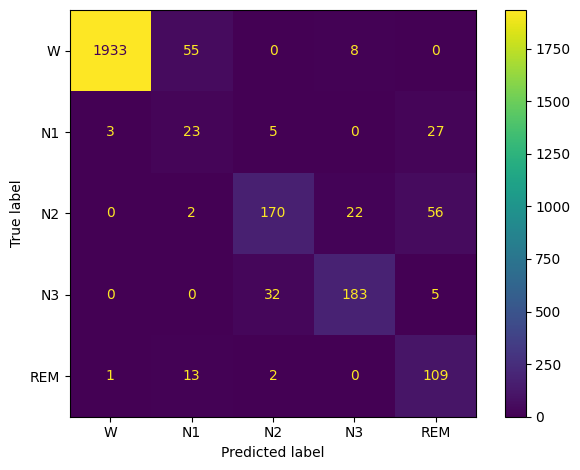

In [6]:
if RUN_POC:
    print("=== POC: quick 1-split ===")
    records_poc, fs = build_subject_records(POC_SUBJECTS, recordings=POC_RECORDINGS, target_hz=TARGET_HZ)
    available = list(records_poc.keys())
    assert len(available) >= 2, "Need at least 2 subjects for POC."
    # 2 train, 1 val (or 80/20 by subject if >3)
    rng = np.random.default_rng(SEED); rng.shuffle(available)
    if len(available) >= 3:
        tr_subj, va_subj = available[:2], available[2:3]
    else:
        split = int(round(0.8*len(available))); tr_subj, va_subj = available[:split], available[split:]

    X_tr, y_tr = stack_subjects(records_poc, tr_subj)
    X_va, y_va = stack_subjects(records_poc, va_subj)
    in_len = X_tr.shape[-1]

    model_poc = train_one_split(X_tr, y_tr, X_va, y_va, in_len=in_len, fs=fs,
                                epochs=EPOCHS_POC, seed=SEED, num_workers=NUM_WORKERS)

    # evaluate on val (no HMM in POC)
    y_true, y_pred = [], []
    from torch.utils.data import DataLoader
    va_loader = DataLoader(EpochDS(X_va, y_va, train=False, fs=fs),
                           batch_size=256, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    model_poc.eval()
    with torch.inference_mode():
        for xb, yb in va_loader:
            logits = model_poc(xb.to(device)).softmax(1).cpu().numpy()
            y_pred.append(logits.argmax(1)); y_true.append(yb.numpy())
    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    acc = accuracy_score(y_true, y_pred); f1 = f1_score(y_true, y_pred, average='macro')
    cm  = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])

    # per-class from CM
    labels = ['W','N1','N2','N3','REM']; eps=1e-12
    per_class = {}
    for i, name in enumerate(labels):
        tp = cm[i,i]; fn = cm[i,:].sum()-tp; fp = cm[:,i].sum()-tp
        prec = tp/(tp+fp+eps); rec = tp/(tp+fn+eps); f1c = 2*prec*rec/(prec+rec+eps)
        per_class[name] = {'precision': float(prec), 'recall': float(rec), 'f1': float(f1c)}

    json.dump({'split':'POC','val_acc':float(acc),'val_macroF1':float(f1),'per_class':per_class},
              open(f"{RESULTS_DIR}/metrics_poc.json","w"), indent=2)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot(values_format='d'); plt.tight_layout(); plt.savefig(f"{RESULTS_DIR}/confusion_poc.png", dpi=150)
    print(f"POC  acc={acc*100:.2f}%  macroF1={f1*100:.2f}%  -> artifacts in {RESULTS_DIR}/metrics_poc.json & confusion_poc.png")


=== 5-fold subject-wise CV ===


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]


/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)
/tmp/ipykernel_10004/1132995078.py:11: RuntimeWarning: Highpass cutoff frequency 16.0 is greater than lowpass cutoff frequency 0.7, setting values to 0 and Nyquist.
  raw = mne.io.read_raw_edf(psg_path, preload=True, verbose=False)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1101 samples (11.010 s)

Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]

FOLD 1  train subj 13  val subj 3  test subj 4
  ep01  tr_acc  84.9  va_acc  90.7  vaF1  74.3
  ep02  tr_acc  89.9  va_acc  88.9  vaF1  73.3
  ep03  tr_acc  90.7  va_acc  90.7  vaF1  76.8
  ep04  tr_acc  91.5  va_acc  89.0  vaF1  73.5
  ep05  tr_

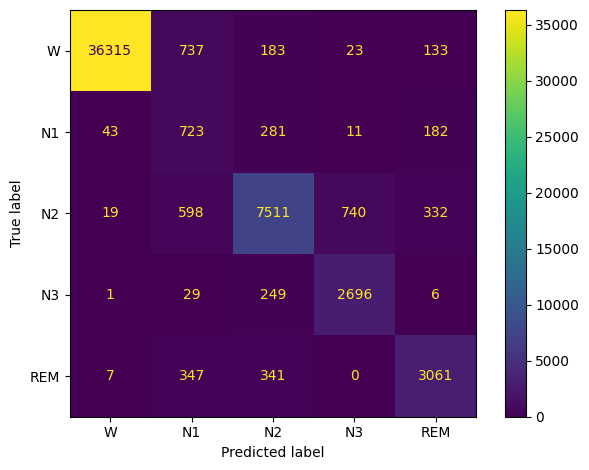

In [ ]:
if RUN_CV:
    print("=== 5-fold subject-wise CV ===")
    records_cv, fs = build_subject_records(CV_SUBJECTS, recordings=CV_RECORDINGS, target_hz=TARGET_HZ)
    subjects = list(records_cv.keys())
    assert len(subjects) >= 5, f"Need >=5 subjects for 5-fold CV; have {len(subjects)}"
    in_len = next(iter(records_cv[subjects[0]]))['X'].shape[-1]

    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    fold_metrics = []; agg_cm = np.zeros((5,5), dtype=int)
    log_trans = build_log_trans(alpha_stay=0.88)

    for fold, (tr_idx, te_idx) in enumerate(kf.split(subjects), 1):
        tr_subj = [subjects[i] for i in tr_idx]
        te_subj = [subjects[i] for i in te_idx]

        # small val split by subject from train (20% or at least 1 subject)
        rng = np.random.default_rng(SEED + fold); rng.shuffle(tr_subj)
        n_val = max(1, int(round(0.2*len(tr_subj))))
        va_subj, tr_subj = tr_subj[:n_val], tr_subj[n_val:]


            # >>> SAVE SPLIT HERE <<<
        def n_epochs_for(subj_list):
            # count epochs per subject from your already-loaded records_cv
            return {int(s): int(sum(rec['X'].shape[0] for rec in records_cv[s])) for s in subj_list}

        split = {
            "seed": int(SEED),
            "fold": int(fold),
            "subjects_all": [int(s) for s in subjects],
            "train_subjects": [int(s) for s in tr_subj],
            "val_subjects":   [int(s) for s in va_subj],
            "test_subjects":  [int(s) for s in te_subj],
            "epoch_counts": {
                "train": n_epochs_for(tr_subj),
                "val":   n_epochs_for(va_subj),
                "test":  n_epochs_for(te_subj),
            },
            "preproc": {"bandpass":[0.3,40.0], "epoch_s":30, "target_hz":int(TARGET_HZ),
                        "channels":["Fpz-Cz","Pz-Oz"]},
            "hmm": {"alpha_stay": 0.88}
        }
        with open(f"{RESULTS_DIR}/splits/fold{fold}.json","w") as f:
            s = json.load(f)
        tr_subj = s["train_subjects"]; va_subj = s["val_subjects"]; te_subj = s["test_subjects"]

        X_tr, y_tr = stack_subjects(records_cv, tr_subj)
        X_va, y_va = stack_subjects(records_cv, va_subj)

        print(f"\nFOLD {fold}  train subj {len(tr_subj)}  val subj {len(va_subj)}  test subj {len(te_subj)}")
        model = train_one_split(X_tr, y_tr, X_va, y_va, in_len=in_len, fs=fs,
                                epochs=EPOCHS_CV, seed=fold, num_workers=NUM_WORKERS)

        acc, f1, kap, cm, y_true, y_pred = eval_records(model, records_cv, te_subj, smooth=True, log_trans=log_trans)
        agg_cm += cm
        fold_metrics.append({'acc':acc, 'macroF1':f1, 'kappa':kap})
        print(f"  TEST  acc {acc*100:5.2f}%  macroF1 {f1*100:5.2f}%  kappa {kap:0.3f}")

    # summarize
    accs  = [m['acc'] for m in fold_metrics]
    f1s   = [m['macroF1'] for m in fold_metrics]
    kaps  = [m['kappa'] for m in fold_metrics]
    summary = {
        'cv_folds': len(fold_metrics),
        'acc_mean': float(np.mean(accs)),  'acc_std': float(np.std(accs)),
        'macroF1_mean': float(np.mean(f1s)), 'macroF1_std': float(np.std(f1s)),
        'kappa_mean': float(np.mean(kaps)),  'kappa_std': float(np.std(kaps))
    }
    print("\nCV summary:", summary)

    # per-class from aggregated CM
    labels = ['W','N1','N2','N3','REM']; eps=1e-12
    per_class = {}
    for i, name in enumerate(labels):
        tp = agg_cm[i,i]; fn = agg_cm[i,:].sum()-tp; fp = agg_cm[:,i].sum()-tp
        prec = tp/(tp+fp+eps); rec = tp/(tp+fn+eps); f1c = 2*prec*rec/(prec+rec+eps)
        per_class[name] = {'precision': float(prec), 'recall': float(rec), 'f1': float(f1c)}

    json.dump({'split':'5fold-CV','summary':summary,'per_class':per_class,
               'notes':'2-ch EEG (Fpz-Cz,Pz-Oz); 0.3–40 Hz; 30s epochs; HMM alpha_stay=0.88'},
              open(f"{RESULTS_DIR}/metrics_cv.json","w"), indent=2)

    disp = ConfusionMatrixDisplay(agg_cm, display_labels=labels)
    disp.plot(values_format='d'); plt.tight_layout(); plt.savefig(f"{RESULTS_DIR}/confusion_cv.png", dpi=150)
    print(f"CV artifacts -> {RESULTS_DIR}/metrics_cv.json & confusion_cv.png")
